This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
figname = '../paper/fig_crowding'

In [2]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-04-04
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 0.75, 'contrast': 0.5, 'sf_0': 0.2, 'B_sf': 0.08, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 382, 'dim2': 618, 'lr': 0.005, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.3, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-04-04', 'seed': 2019, 'N_cv': 2, 'do_compute': True}
Overwriting train.py
2019-04-04T10:43:08+02:00

CPython 3.7.3rc1
IPython 7.4.0

numpy 1.16.2
matplotlib 3.0.2
torch 1.0.1.post2

compiler   : GCC 8.3.0
sy

# Training the WhatWhere network

In [3]:
%ls -lh ../data/*pt

-rw-r--r-- 1 dauce dauce 6,9M mars  28 08:04 ../data/2019-03-27_train.pt
-rw-r--r-- 1 dauce dauce 6,9M mars  28 20:40 ../data/2019-03-28_train.pt
-rw-r--r-- 1 dauce dauce 7,8M avril  3 13:02 ../data/2019-04-03_train.pt
-rw-r--r-- 1 dauce dauce 1,7M avril  3 11:03 ../data/MNIST_cnn.pt


In [4]:
%ls -lh ../data/*npy

-rw-r--r-- 1 dauce dauce  800 mars  14 14:37 ../data/2019-02-13-add-crowding-test-continued-result.npy
-rw-r--r-- 1 dauce dauce  880 mars  14 14:37 ../data/2019-02-13-add-crowding-test-result.npy
-rw-r--r-- 1 dauce dauce  12M mars   3 08:18 ../data/2019-03-07_CNS.npy
-rw-r--r-- 1 dauce dauce  17K avril  1 23:06 ../data/2019-03-29-crowding-result.npy
-rw-r--r-- 1 dauce dauce  481 mars  29 15:13 ../data/2019-03-29-crowding-test-result.npy
-rw-r--r-- 1 dauce dauce 2,4K avril  4 10:19 ../data/2019-04-02-crowding-contrast-result.npy
-rw-r--r-- 1 dauce dauce  24K sept.  7  2018 ../data/MNIST_accuracy.npy


In [5]:
from main_orig import init
#args = init(filename='debug')
args = init(filename='../data/2019-03-28')
from whatWhere import WhatWhere
whatWhere = WhatWhere(args, save = True)
print('starting training...')
filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-15_train_b.pt"
%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

whatWhere.train(filename_train)

1
2
3
starting training...
-rw-r--r-- 1 dauce dauce 6,9M mars  28 20:40 ../data/2019-03-28_train.pt
Loading file ../data/2019-03-28_train.pt


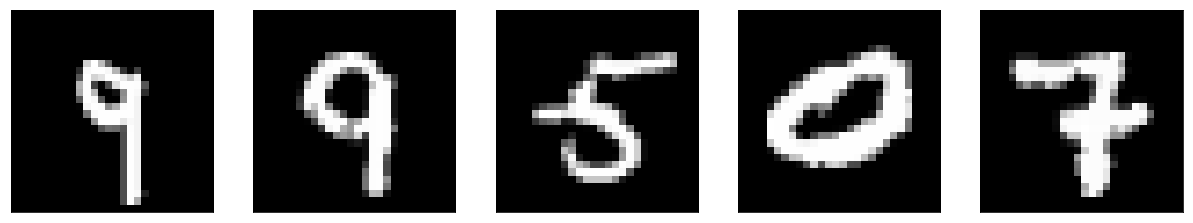

In [6]:
data_d, label_d = next(iter(whatWhere.display.loader_test))
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data_d[i_ax+5, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])

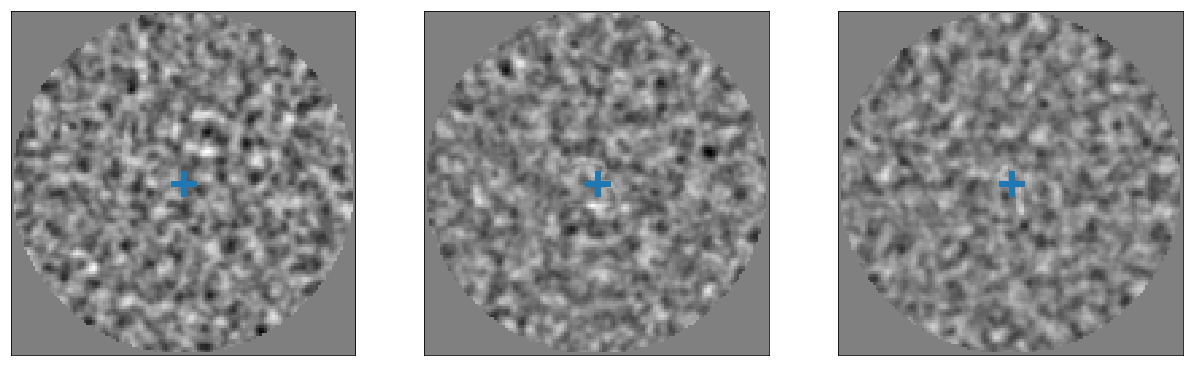

In [7]:
N_plot = 3
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    data_fullfield, i_offset, j_offset = whatWhere.display.draw(data_d[i_ax, 0, :, :].numpy())
    ax = whatWhere.display.show(ax, data_fullfield)


In [10]:
from main_orig import init
#args = init(filename='debug')
args = init(filename='../data/2019-03-28')
data, label = next(iter(whatWhere.loader_train)) 
print(data.shape)
print(label.shape)
pred = whatWhere.model.forward(data).argmax(dim=1, keepdim=True)
print(pred.eq(label.view_as(pred)).sum())
print(whatWhere.pred_accuracy(data, label)) #/whatWhere.args.minibatch_size)


torch.Size([100, 1536])
torch.Size([100, 128])


RuntimeError: shape '[100, 1]' is invalid for input of size 12800

In [22]:
data, label = next(iter(whatWhere.loader_test)) 
print(data.shape)
print(label.shape)
pred = whatWhere.model.forward(data).argmax(dim=1, keepdim=True)
print(pred.eq(label.view_as(pred)).sum())
print(whatWhere.pred_accuracy(data, label))


torch.Size([10000, 1536])
torch.Size([10000])
tensor(8244)
0.8244


AxesSubplot(0.125,0.125;0.168478x0.755)
[0.08080373 0.06014004 0.08562995 0.10916185 0.10660177 0.09984117
 0.10017893 0.10008828 0.05583061 0.0444273  0.07765636 0.11293372
 0.10698959 0.09991945 0.10002976 0.10009095 0.05305685 0.04246621
 0.07007557 0.10739712 0.11125693 0.101064   0.09991387 0.10010269
 0.07979369 0.05870956 0.06333867 0.08274507 0.10639674 0.10086569
 0.10016089 0.10012595 0.1546255  0.1105901  0.06281828 0.08059485
 0.1004248  0.10145599 0.10030297 0.10015301 0.2934239  0.1984053
 0.08826562 0.08023313 0.10121854 0.10290723 0.10040531 0.10018933
 0.4602206  0.27626127 0.11105528 0.10057864 0.10096153 0.10250113
 0.10024224 0.10013159 0.5929968  0.32052603 0.14522545 0.14420861
 0.1199366  0.0989053  0.09986837 0.10002544 0.64608437 0.31884912
 0.17199044 0.1303188  0.11584667 0.09555976 0.09930174 0.10003876
 0.6590433  0.32004184 0.14448836 0.09419799 0.10334084 0.10511233
 0.09987888 0.10021463 0.6721424  0.36697456 0.14114016 0.08096103
 0.0965366  0.10579066 

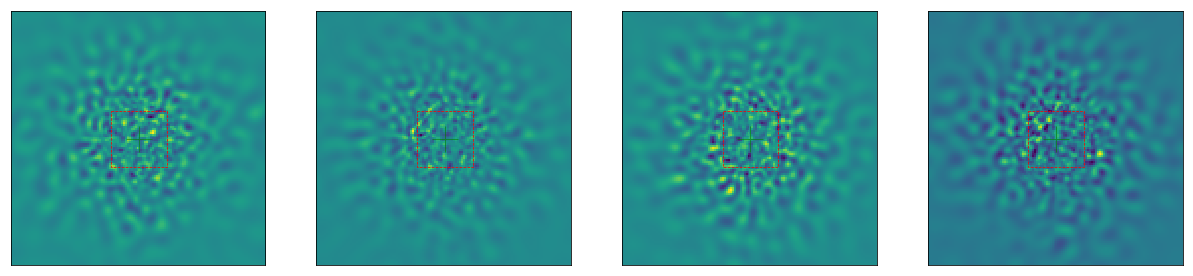

In [11]:
N_plot = 8
fig, axs = plt.subplots(1, 4, figsize = (21, 8))
for i_ax, ax in enumerate(axs):
    num = i_ax+20
    data_fullfield = whatWhere.retina.retina_invert(data[num,:].numpy())
    ax = whatWhere.retina.show(ax, data_fullfield)
    print(ax)
    print(label[num].numpy()) #ax.title(label[i_ax].numpy())
    print(pred[num]) #ax.title(label[i_ax].numpy())

In [19]:
print(f'sf_0 : {args.sf_0}, B_sf : {args.B_sf}, acc : {acc}')

sf_0 : 1.0, B_sf : 0.25, acc : 0.8244


In [29]:
result[period] = {} 

In [30]:
result[period][prop] = acc

FIC_NAME = '../data/2019-03-29-crowding-test'
np.save(FIC_NAME + '-result.npy', result)

res = np.load(FIC_NAME + '-result.npy')
print(res)

In [ ]:
from retina import Display


FIC_NAME = '../data/2019-03-29-crowding-result.npy'
res = np.load(FIC_NAME).tolist()
shape = len(res), len(res[1])
im = np.zeros(shape)
for i, period in enumerate(range(1,21)):
    for j, prop in enumerate(np.arange(0.25,2.25,0.25)):
        im[i, j] = res[period][prop]
        
FIC_NAME = '../data/2019-04-02-crowding-contrast-result.npy'
res = np.load(FIC_NAME).tolist()
shape = len(res), len(res[1])
im2 = np.zeros(shape)
for i, period in enumerate(range(1,21)):
    for j, prop in enumerate((0.5, 0.7)):
        im2[i, j] = res[period][prop]

fig = plt.figure(figsize = (10,10))

period = 2
args.sf_0 = 1/period
args.B_sf = 1/period
args.contrast = 0.5
ax = fig.add_subplot(3, 3, 1)
ax.set_title(f'Period = {period}, contrast = {args.contrast}', fontsize = 14)
display = Display(args, save = False)
data, _ = next(iter(display.loader_test))
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
args.contrast = 0.5
ax = fig.add_subplot(3, 3, 2)
ax.set_title(f'Period = {period}, contrast = {args.contrast}', fontsize = 14)
display = Display(args, save = False)
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

period = 18
args.sf_0 = 1/period
args.B_sf = 1/period
args.contrast = 0.5
ax = fig.add_subplot(3, 3, 3)
ax.set_title(f'Period = {period}, contrast = {args.contrast}', fontsize = 14)
display = Display(args, save = False)
data_fullfield, i_offset, j_offset = display.draw(data[4, 0, :, :].numpy(), i_offset=-15, j_offset=15)
ax = display.show(ax, data_fullfield)

ax = fig.add_subplot(3, 1, (2,3))
#ax.fill_between(range(1,21), im[:,3], color = 'b', alpha = .3)
ax.plot(range(1,21), im[:,3], linewidth = 3, label = 'contrast = 0.3')
ax.plot(range(1,21), im2[:,0], linewidth = 3, label = 'contrast = 0.5')
ax.plot(range(1,21), im2[:,1], linewidth = 3, label = 'contrast = 0.7')
_ = ax.set_xticks(range(1,21))
_ = ax.set_xlabel('Noise spatial period (pixels)', fontsize = 18)
_ = ax.set_xlim([1, 20])
_ = ax.set_ylabel('Class accuracy', fontsize = 18)
_ = ax.set_ylim([0, 0.9])
_ = ax.plot([1, 20],[0.1, 0.1], ':')
_ = ax.legend()



In [59]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 15,
 'offset_max': 30,
 'noise': 1.0,
 'contrast': 0.3,
 'sf_0': 0.05555555555555555,
 'B_sf': 0.05555555555555555,
 'N_theta': 6,
 'N_azimuth': 16,
 'N_eccentricity': 8,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 500,
 'dim2': 2000,
 'lr': 0.001,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.2,
 'momentum': 0.1,
 'epochs': 25,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-03-28',
 'seed': 2019,
 'N_cv': 8,
 'do_compute': True}